# 第9章: RNN, CNN

In [2]:
'''
インポート群
なるべく問題ごとにインポートしていますが，抜けがないように一応上にまとめています．
'''
import numpy as np
import pandas as pd
import re
import torch
from tqdm import tqdm
from gensim.models import KeyedVectors
import torch
from tqdm import tqdm
from transformers import AutoTokenizer
from transformers import AutoTokenizer
from transformers import AdamW, BertModel
code_regex = re.compile('[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥％]')

### 80. ID番号への変換
問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に1，2番目に頻出する単語に2，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて0とせよ．

In [4]:
# 単語をkey,IDをvalueとした辞書を作成
def word_to_ID(train_path, valid_path, test_path):
    train_df = pd.read_csv(train_path, sep='\t', encoding='utf-8', names=['label', 'text'])
    valid_df = pd.read_csv(valid_path, sep='\t', encoding='utf-8', names=['label', 'text'])
    test_df = pd.read_csv(test_path, sep='\t', encoding='utf-8', names=['label', 'text'])
    df = pd.concat([train_df, valid_df, test_df])

    # 重複を許した全単語のリストを作成
    words = [code_regex.sub('', word) for sentence in df['text'] for word in sentence.split(' ') if code_regex.sub('', word) !='']
    # リストからSiries型に変換して単語の出現頻度を取得
    freqs = pd.Series(words).value_counts()
    word_dic = {}
    k = 1 # 単語IDの添え字
    for key, value in freqs.iteritems():
        if value < 2:
            word_dic[key] = 0
        else:
            word_dic[key] = k
            k += 1
    return word_dic

# 与えられた単語列をIDに変換する関数
def sentence_to_ID(sentence, word_dic):
    return [word_dic[code_regex.sub('', word)] for word in sentence.split(' ') \
            if code_regex.sub('', word) != '' and code_regex.sub('', word) in word_dic.keys()]

In [5]:
word_dic = word_to_ID('train.txt', 'valid.txt', 'test.txt')
print(f'語彙数{len(word_dic)}')
train_df = pd.read_csv('train.txt', sep='\t', encoding='utf-8', names=['label', 'text'])
train_features = [sentence_to_ID(sentence, word_dic) for sentence in train_df['text']]
train_features = pd.DataFrame(train_features).fillna(0).astype('int')
train_features

語彙数21648


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,268,351,1234,10,1574,93,2282,2470,5006,0,0,0,0,0,0,0,0,0,0
1,2034,2,7533,2208,23,7518,7426,7381,10913,16,2194,7,2518,391,0,0,0,0,0
2,1116,791,329,1514,1591,1,10866,214,29,197,0,0,0,0,0,0,0,0,0
3,7707,1720,73,11248,55,4804,2495,0,1827,0,0,0,0,0,0,0,0,0,0
4,5,4681,638,49,1461,3387,350,3606,4710,9,8154,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10666,2311,3102,34,9497,2817,501,2075,10080,93,0,0,0,0,0,0,0,0,0,0
10667,10332,3662,0,0,3026,4764,560,1201,1185,3,8504,0,0,0,0,0,0,0,0
10668,28,25,2,7435,0,6690,240,201,1,60,56,0,0,0,0,0,0,0,0
10669,174,43,701,132,4,213,638,4086,0,0,0,0,0,0,0,0,0,0,0


### 81. RNNによる予測

In [211]:
# モデル定義
dw = 300
dh = 50
class RNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = torch.nn.Embedding(len(word_dic)+1, dw, padding_idx=len(word_dic))
        self.rnn = torch.nn.RNN(dw, dh, batch_first=True)
        self.fc = torch.nn.Linear(dh, 4)
    def forward(self, x):
        y, h = self.rnn(self.emb(x), None)
        y = y[:,-1,:]
        y = self.fc(y)
        return torch.nn.functional.softmax(y, dim=1)
model = RNN()
print(model)

RNN(
  (emb): Embedding(19542, 300, padding_idx=19541)
  (rnn): RNN(300, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=4, bias=True)
)


In [212]:
xx = torch.randint(0, len(word_dic), (1, 19))
y_pred = model(xx)
print(y_pred)
print(y_pred.shape)

tensor([[0.2730, 0.2182, 0.3001, 0.2088]], grad_fn=<SoftmaxBackward>)
torch.Size([1, 4])


## 82. 確率的勾配降下法による学習

In [251]:
# モデル定義
dw = 300
dh = 50
class RNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = torch.nn.Embedding(len(word_dic)+2, dw, padding_idx=len(word_dic)+1)
        self.rnn = torch.nn.RNN(dw, dh, batch_first=True)
        self.fc = torch.nn.Linear(dh, 4)
    def forward(self, x):
        y, h = self.rnn(self.emb(x), None)
        y = y[:,-1,:]
        y = self.fc(y)
        return torch.nn.functional.softmax(y, dim=1)
        #return y

In [7]:
#  ラベルを数字に変換
def label_to_num(labels):
    Y = []
    for label in labels:
        if label == "b":
            Y.append(0)
        elif label == "t":
            Y.append(1)
        elif label == "e":
            Y.append(2)
        elif label == "m":
            Y.append(3)
    return Y

In [8]:
# 学習データの読み込み
train_df = pd.read_csv('train.txt', sep='\t', encoding='utf-8', names=['label', 'text'])
train_features = [sentence_to_ID(sentence, word_dic) for sentence in train_df['text']]
train_features = pd.DataFrame(train_features).fillna(0)
Y = torch.tensor(label_to_num(train_df['label'].values), dtype=torch.long)
train_Dataset = torch.utils.data.TensorDataset(torch.tensor(train_features.values, dtype=torch.long), Y)
train_DataLoader = torch.utils.data.DataLoader(
    dataset=train_Dataset, 
    num_workers=6
)

# 評価データの読み込み
test_df = pd.read_csv('test.txt', sep='\t', encoding='utf-8', names=['label', 'text'])
test_features = [sentence_to_ID(sentence, word_dic) for sentence in test_df['text']]
test_features = pd.DataFrame(test_features).fillna(0)
Y = torch.tensor(label_to_num(test_df['label'].values), dtype=torch.long)
test_Dataset = torch.utils.data.TensorDataset(torch.tensor(test_features.values, dtype=torch.long), Y)
test_DataLoader = torch.utils.data.DataLoader(
    dataset=test_Dataset,
    num_workers=6,
    shuffle=False,
)

In [254]:
# 学習の実行
def run_train(DataLoader, net, device):
    net.train()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
    
    losses = []
    loss_ = 0
    for x, y in DataLoader:
        '''x = x.to(device)
        y = y.to(device)'''
        y_pred = net(x)

        loss = criterion(y_pred, y) # 推論値と正解データの誤差を計算
        loss_ += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(loss_ / len(DataLoader))

    return losses

# 評価データで実行
def run_test(DataLoader, net, device):
    net.eval()
    criterion = torch.nn.CrossEntropyLoss()
    
    losses = []
    loss_ = 0
    with torch.no_grad(): # 勾配を計算しない
        for x, y in DataLoader:
            '''x = x.to(device)
            y = y.to(device)'''
            y_pred = net(x)

            loss = criterion(y_pred, y) # 推論値と正解データの誤差を計算
            loss_ += loss.item()
        
        losses.append(loss_ / len(DataLoader))

    return losses

100%|██████████| 10/10 [29:21<00:00, 176.10s/it]


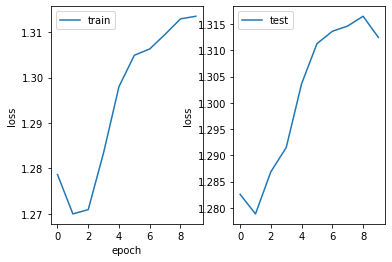

In [255]:
from matplotlib import pyplot as plt
from tqdm import tqdm

train_loss = []
test_loss = []
epoch_num = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = RNN()
#net = net.to(device)
for epoch in tqdm(range(epoch_num)):
    train_loss.append(run_train(train_DataLoader, net, device))
    test_loss.append(run_test(test_DataLoader, net, device))

# プロット領域の定義
fig = plt.figure()

# 描画領域を追加
train_g = fig.add_subplot(1, 2, 1)
valid_g = fig.add_subplot(1, 2, 2)

x = [i for i in range(epoch_num)]

# プロット
train_g.plot(x, train_loss, label='train')
train_g.set_xlabel('epoch')
train_g.set_ylabel('loss')
train_g.legend()

valid_g.plot(x, test_loss, label='test')
valid_g.set_ylabel('loss')
valid_g.legend()

plt.show()

## 83. ミニバッチ化・GPU上での学習

In [14]:
# モデルの定義
dw = 300
dh = 50
class RNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = torch.nn.Embedding(len(word_dic)+1, dw)
        self.rnn = torch.nn.RNN(dw, dh, batch_first=True)
        self.fc = torch.nn.Linear(dh, 4)
    def forward(self, x, h=None):
        x = self.emb(x)
        y, h = self.rnn(x, h)
        y = y[:,-1,:] # 最後のステップ
        y = self.fc(y)
        return torch.nn.functional.softmax(y, dim=1)

In [8]:
train_DataLoader = torch.utils.data.DataLoader(
    dataset=train_Dataset, 
    batch_size=64
)
test_DataLoader = torch.utils.data.DataLoader(
    dataset=test_Dataset,
    batch_size=64,
    shuffle=False,
)

In [10]:
# 学習の実行
def run_train(DataLoader, net, device):
    net.train()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
    
    losses = []
    loss_ = 0
    for x, y in DataLoader:
        x = x.to(device)
        y = y.to(device)
        y_pred = net(x)

        loss = criterion(y_pred, y) # 推論値と正解データの誤差を計算
        loss_ += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(loss_ / len(DataLoader))

    return losses

# 評価データで実行
def run_test(DataLoader, net, device):
    net.eval()
    criterion = torch.nn.CrossEntropyLoss()
    
    losses = []
    loss_ = 0
    with torch.no_grad(): # 勾配を計算しない
        for x, y in DataLoader:
            x = x.to(device)
            y = y.to(device)
            y_pred = net(x)

            loss = criterion(y_pred, y) # 推論値と正解データの誤差を計算
            loss_ += loss.item()
        
        losses.append(loss_ / len(DataLoader))

    return losses

100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


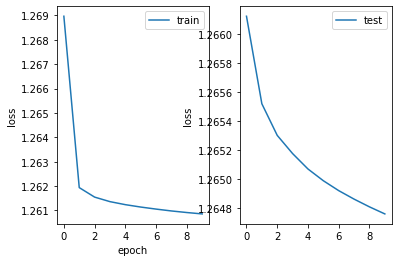

In [15]:
from matplotlib import pyplot as plt
from tqdm import tqdm

train_loss = []
test_loss = []
epoch_num = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = RNN()
net = net.to(device)
for epoch in tqdm(range(epoch_num)):
    train_loss.append(run_train(train_DataLoader, net, device))
    test_loss.append(run_test(test_DataLoader, net, device))

# プロット領域の定義
fig = plt.figure()

# 描画領域を追加
train_g = fig.add_subplot(1, 2, 1)
valid_g = fig.add_subplot(1, 2, 2)

x = [i for i in range(epoch_num)]

# プロット
train_g.plot(x, train_loss, label='train')
train_g.set_xlabel('epoch')
train_g.set_ylabel('loss')
train_g.legend()

valid_g.plot(x, test_loss, label='test')
valid_g.set_ylabel('loss')
valid_g.legend()

plt.show()

## 84. 単語ベクトルの導入

In [18]:
# gensimでバイナリファイルをロード
model = KeyedVectors.load_word2vec_format("./GoogleNews-vectors-negative300.bin", binary=True)

In [30]:
# 単語埋め込みの初期化関数
def init_emb(emb):
    k = 0
    tmp = list(word_dic)
    for key in tmp:
        if key in model:
            emb.weight.data[k] = torch.from_numpy(model[key])
            k += 1

In [ ]:
# 学習の実行
def run_train(DataLoader, net, device):
    net.train()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
    
    losses = []
    loss_ = 0
    for x, y in DataLoader:
        x = x.to(device)
        y = y.to(device)
        y_pred = net(x)

        loss = criterion(y_pred, y) # 推論値と正解データの誤差を計算
        loss_ += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(loss_ / len(DataLoader))

    return losses

# 評価データで実行
def run_test(DataLoader, net, device):
    net.eval()
    criterion = torch.nn.CrossEntropyLoss()
    
    losses = []
    loss_ = 0
    with torch.no_grad(): # 勾配を計算しない
        for x, y in DataLoader:
            x = x.to(device)
            y = y.to(device)
            y_pred = net(x)

            loss = criterion(y_pred, y) # 推論値と正解データの誤差を計算
            loss_ += loss.item()
        
        losses.append(loss_ / len(DataLoader))

    return losses

100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


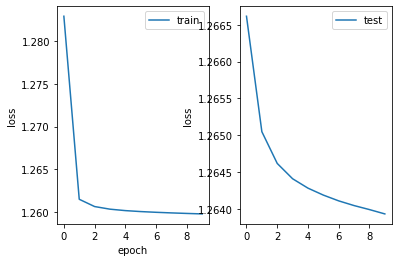

In [31]:
from matplotlib import pyplot as plt
from tqdm import tqdm

train_loss = []
test_loss = []
epoch_num = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = RNN()
init_emb(net.emb) # 単語埋め込みを初期化
net = net.to(device)
for epoch in tqdm(range(epoch_num)):
    train_loss.append(run_train(train_DataLoader, net, device))
    test_loss.append(run_test(test_DataLoader, net, device))

# プロット領域の定義
fig = plt.figure()

# 描画領域を追加
train_g = fig.add_subplot(1, 2, 1)
valid_g = fig.add_subplot(1, 2, 2)

x = [i for i in range(epoch_num)]

# プロット
train_g.plot(x, train_loss, label='train')
train_g.set_xlabel('epoch')
train_g.set_ylabel('loss')
train_g.legend()

valid_g.plot(x, test_loss, label='test')
valid_g.set_ylabel('loss')
valid_g.legend()

plt.show()

### 85. 双方向RNN・多層化

In [42]:
# モデルの定義
dw = 300
dh = 50
class bi_RNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = torch.nn.Embedding(len(word_dic)+1, dw)
        self.rnn1 = torch.nn.RNN(dw, dh, batch_first=True, bidirectional=True)
        self.rnn2 = torch.nn.RNN(dh*2, dh, batch_first=True, bidirectional=True)
        self.rnn3 = torch.nn.RNN(dh*2, dh, batch_first=True, bidirectional=True)
        self.fc = torch.nn.Linear(dh*2, 4)
    def forward(self, x):
        y, h = self.rnn1(self.emb(x), None)
        y, h = self.rnn2(y, h)
        y, h = self.rnn3(y, h)
        y = y[:,-1,:] # 最後のステップ
        y = self.fc(y)
        return torch.nn.functional.softmax(y, dim=1)
print(bi_RNN())

bi_RNN(
  (emb): Embedding(19542, 300)
  (rnn1): RNN(300, 50, batch_first=True, bidirectional=True)
  (rnn2): RNN(100, 50, batch_first=True, bidirectional=True)
  (rnn3): RNN(100, 50, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=100, out_features=4, bias=True)
)


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


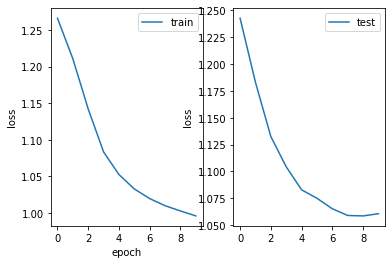

In [43]:
from matplotlib import pyplot as plt
from tqdm import tqdm

train_loss = []
test_loss = []
epoch_num = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = bi_RNN()
init_emb(net.emb) # 単語埋め込みを初期化
net = net.to(device)
for epoch in tqdm(range(epoch_num)):
    train_loss.append(run_train(train_DataLoader, net, device))
    test_loss.append(run_test(test_DataLoader, net, device))

# プロット領域の定義
fig = plt.figure()

# 描画領域を追加
train_g = fig.add_subplot(1, 2, 1)
valid_g = fig.add_subplot(1, 2, 2)

x = [i for i in range(epoch_num)]

# プロット
train_g.plot(x, train_loss, label='train')
train_g.set_xlabel('epoch')
train_g.set_ylabel('loss')
train_g.legend()

valid_g.plot(x, test_loss, label='test')
valid_g.set_ylabel('loss')
valid_g.legend()

plt.show()

### 86. 畳み込みニューラルネットワーク (CNN)

In [45]:
dw = 300
dh = 50
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = torch.nn.Embedding(len(word_dic)+1, dw)

        self.conv1 = torch.nn.Conv1d(dw, dh, kernel_size=3, padding=1)
        self.pool1 = torch.nn.MaxPool1d(kernel_size=2)
        self.Linear1 = torch.nn.Linear(450, 4)
    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], x.shape[2], x.shape[1])
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.pool1(x)

        x = x.view(-1, self.num_flat_features(x))
        
        x = self.Linear1(x)
        return torch.nn.functional.softmax(x, dim=1)
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [46]:
cnn = CNN()
xx = torch.randint(0, len(word_dic), (1, 19))
y_pred = cnn(xx)
y_pred

tensor([[0.1831, 0.2404, 0.2780, 0.2985]], grad_fn=<SoftmaxBackward0>)

### 87. 確率的勾配降下法によるCNNの学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題86で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [40]:
dw = 300
dh = 50
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = torch.nn.Embedding(len(word_dic)+1, dw)

        self.conv1 = torch.nn.Conv1d(dw, dh, kernel_size=3, padding=1)
        self.pool1 = torch.nn.MaxPool1d(kernel_size=2)
        self.Linear1 = torch.nn.Linear(450, 4)
    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], x.shape[2], x.shape[1])
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.pool1(x)

        x = x.view(-1, self.num_flat_features(x))
        
        x = self.Linear1(x)
        return torch.nn.functional.softmax(x, dim=1)
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = CNN()
y = net(torch.randint(0, len(word_dic), (1, 19)))

In [41]:
#  ラベルを数字に変換
def label_to_num(labels):
    Y = []
    for label in labels:
        if label == "b":
            Y.append(0)
        elif label == "t":
            Y.append(1)
        elif label == "e":
            Y.append(2)
        elif label == "m":
            Y.append(3)
    return Y

In [42]:
# 学習データの読み込み
train_df = pd.read_csv('train.txt', sep='\t', encoding='utf-8', names=['label', 'text'])
train_features = [sentence_to_ID(sentence, word_dic) for sentence in train_df['text']]
train_features = pd.DataFrame(train_features).fillna(0)
Y = torch.tensor(label_to_num(train_df['label'].values), dtype=torch.long)
train_Dataset = torch.utils.data.TensorDataset(torch.tensor(train_features.values, dtype=torch.long), Y)
train_DataLoader = torch.utils.data.DataLoader(
    dataset=train_Dataset, 
    num_workers=3
)

# 評価データの読み込み
test_df = pd.read_csv('test.txt', sep='\t', encoding='utf-8', names=['label', 'text'])
test_features = [sentence_to_ID(sentence, word_dic) for sentence in test_df['text']]
test_features = pd.DataFrame(test_features).fillna(0)
test_features['17'] = 0
test_features['18'] = 0
Y = torch.tensor(label_to_num(test_df['label'].values), dtype=torch.long)
test_Dataset = torch.utils.data.TensorDataset(torch.tensor(test_features.values, dtype=torch.long), Y)
test_DataLoader = torch.utils.data.DataLoader(
    dataset=test_Dataset,
    num_workers=3,
    shuffle=False,
)

In [43]:
# 学習の実行
def run_train(DataLoader, net, device):
    net.train()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=3e-5)
    
    losses = []
    loss_ = 0
    for x, y in DataLoader:
        x = x.to(device)
        y = y.to(device)
        y_pred = net(x)

        loss = criterion(y_pred, y) # 推論値と正解データの誤差を計算
        loss_ += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(loss_ / len(DataLoader))

    return losses

# 評価データで実行
def run_test(DataLoader, net, device):
    net.eval()
    criterion = torch.nn.CrossEntropyLoss()
    
    losses = []
    loss_ = 0
    with torch.no_grad(): # 勾配を計算しない
        for x, y in DataLoader:
            x = x.to(device)
            y = y.to(device)
            y_pred = net(x)

            loss = criterion(y_pred, y) # 推論値と正解データの誤差を計算
            loss_ += loss.item()
        
        losses.append(loss_ / len(DataLoader))

    return losses

100%|██████████| 10/10 [24:37<00:00, 147.75s/it]


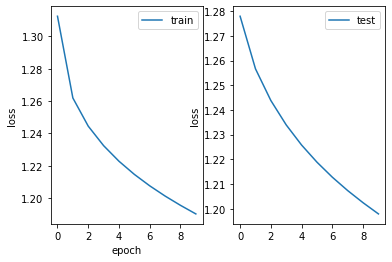

In [44]:
from matplotlib import pyplot as plt
from tqdm import tqdm

train_loss = []
test_loss = []
epoch_num = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = CNN()
net = net.to(device)
for epoch in tqdm(range(epoch_num)):
    train_loss.append(run_train(train_DataLoader, net, device))
    test_loss.append(run_test(test_DataLoader, net, device))

# プロット領域の定義
fig = plt.figure()

# 描画領域を追加
train_g = fig.add_subplot(1, 2, 1)
valid_g = fig.add_subplot(1, 2, 2)

x = [i for i in range(epoch_num)]

# プロット
train_g.plot(x, train_loss, label='train')
train_g.set_xlabel('epoch')
train_g.set_ylabel('loss')
train_g.legend()

valid_g.plot(x, test_loss, label='test')
valid_g.set_ylabel('loss')
valid_g.legend()

plt.show()

### 88. パラメータチューニング
問題85や問題87のコードを改変し，ニューラルネットワークの形状やハイパーパラメータを調整しながら，高性能なカテゴリ分類器を構築せよ．

In [27]:
dw = 300
dh = 100
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = torch.nn.Embedding(len(word_dic)+1, dw)

        self.conv1 = torch.nn.Conv1d(dw, dh, kernel_size=3, padding=1)
        self.pool1 = torch.nn.MaxPool1d(kernel_size=2)
        self.drop1 = torch.nn.Dropout(0.2)
        self.Linear1 = torch.nn.Linear(900, 4)
    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], x.shape[2], x.shape[1])
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.pool1(x)
        x = self.drop1(x)

        x = x.view(-1, self.num_flat_features(x))
        
        x = self.Linear1(x)
        return torch.nn.functional.softmax(x, dim=1)
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = CNN()
y = net(torch.randint(0, len(word_dic), (1, 19)))

In [7]:
#  ラベルを数字に変換
def label_to_num(labels):
    Y = []
    for label in labels:
        if label == "b":
            Y.append(0)
        elif label == "t":
            Y.append(1)
        elif label == "e":
            Y.append(2)
        elif label == "m":
            Y.append(3)
    return Y

In [8]:
# 学習データの読み込み
train_df = pd.read_csv('train.txt', sep='\t', encoding='utf-8', names=['label', 'text'])
train_features = [sentence_to_ID(sentence, word_dic) for sentence in train_df['text']]
train_features = pd.DataFrame(train_features).fillna(0)
Y = torch.tensor(label_to_num(train_df['label'].values), dtype=torch.long)
train_Dataset = torch.utils.data.TensorDataset(torch.tensor(train_features.values, dtype=torch.long), Y)
train_DataLoader = torch.utils.data.DataLoader(
    dataset=train_Dataset, 
    batch_size=64,
    num_workers=3
)

# 検証データの読み込み
valid_df = pd.read_csv('valid.txt', sep='\t', encoding='utf-8', names=['label', 'text'])
valid_features = [sentence_to_ID(sentence, word_dic) for sentence in valid_df['text']]
valid_features = pd.DataFrame(valid_features).fillna(0)
valid_features['17'] = 0
valid_features['18'] = 0
Y = torch.tensor(label_to_num(valid_df['label'].values), dtype=torch.long)
valid_Dataset = torch.utils.data.TensorDataset(torch.tensor(valid_features.values, dtype=torch.long), Y)
valid_DataLoader = torch.utils.data.DataLoader(
    dataset=valid_Dataset, 
    batch_size=64,
    num_workers=3
)

# 評価データの読み込み
test_df = pd.read_csv('test.txt', sep='\t', encoding='utf-8', names=['label', 'text'])
test_features = [sentence_to_ID(sentence, word_dic) for sentence in test_df['text']]
test_features = pd.DataFrame(test_features).fillna(0)
test_features['17'] = 0
test_features['18'] = 0
Y = torch.tensor(label_to_num(test_df['label'].values), dtype=torch.long)
test_Dataset = torch.utils.data.TensorDataset(torch.tensor(test_features.values, dtype=torch.long), Y)
test_DataLoader = torch.utils.data.DataLoader(
    dataset=test_Dataset,
    num_workers=3,
    batch_size=64,
    shuffle=False,
)

In [15]:
# 学習の実行
def run_train(DataLoader, net, device, optimizer):
    net.train()
    criterion = torch.nn.CrossEntropyLoss()
    
    losses = []
    loss_ = 0
    for x, y in DataLoader:
        x = x.to(device)
        y = y.to(device)
        y_pred = net(x)

        loss = criterion(y_pred, y) # 推論値と正解データの誤差を計算
        loss_ += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(loss_ / len(DataLoader))

    return losses

# 検証データで実行
def run_valid(DataLoader, net, device):
    net.eval()
    criterion = torch.nn.CrossEntropyLoss()
    
    losses = []
    loss_ = 0
    with torch.no_grad(): # 勾配を計算しない
        for x, y in DataLoader:
            x = x.to(device)
            y = y.to(device)
            y_pred = net(x)

            loss = criterion(y_pred, y) # 推論値と正解データの誤差を計算
            loss_ += loss.item()
        
        losses.append(loss_ / len(DataLoader))

    return losses

def test_acc(DataLoader, net, device):
    net.eval()# 訓練モードをオフ
    preds = []
    with torch.no_grad():  
        for x, y in DataLoader:
            x = x.to(device)
            preds.append(net(x))

    result = []
    for pred in preds:
        for b in pred:
            result.append(torch.argmax(b).item())

    count = 0
    for x, y in zip(result, label_to_num(test_df['label'].values)):
        if x == y:
            count += 1
    print(f'Accuracy:{float(count)/float(len(result))}')

In [25]:
# 学習率の調整
lrs = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
X = []
for lr in tqdm(lrs):
    net = CNN()
    net = net.to(device)
    X.append(run_train(train_DataLoader, net, device, torch.optim.SGD(net.parameters(), lr=lr))[0])
SGDs = dict(zip(X, lrs))
X = []
for lr in tqdm(lrs):
    net = CNN()
    net = net.to(device)
    X.append(run_train(train_DataLoader, net, device, torch.optim.Adam(net.parameters(), lr=lr))[0])
Adams = dict(zip(X, lrs))

print(sorted(SGDs.items()))
print(sorted(Adams.items()))


100%|██████████| 6/6 [00:27<00:00,  4.58s/it]

[(1.1923953144850132, 0.1), (1.247394075650655, 0.01), (1.3194864866976252, 0.001), (1.3685427954096994, 1e-06), (1.3878722847578768, 0.0001), (1.4161739256567585, 1e-05)]
[(1.126132651360449, 0.001), (1.2296783131753612, 0.0001), (1.3274292431905599, 1e-05), (1.3476484528558696, 0.01), (1.3482185901995904, 0.1), (1.3751017597621074, 1e-06)]


100%|██████████| 8/8 [01:05<00:00,  8.18s/it]


Accuracy:0.7616191904047976


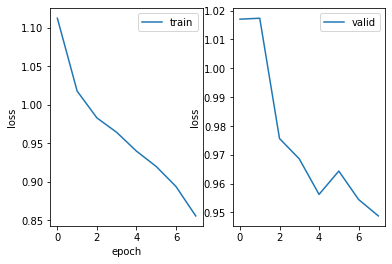

In [28]:
from matplotlib import pyplot as plt
from tqdm import tqdm

train_loss = []
valid_loss = []
epoch_num = 8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = CNN()
net = net.to(device)
for epoch in tqdm(range(epoch_num)):
    train_loss.append(run_train(train_DataLoader, net, device, torch.optim.Adam(net.parameters(), lr=0.001)))
    valid_loss.append(run_valid(valid_DataLoader, net, device))

test_acc(test_DataLoader, net, device)

# プロット領域の定義
fig = plt.figure()

# 描画領域を追加
train_g = fig.add_subplot(1, 2, 1)
valid_g = fig.add_subplot(1, 2, 2)

x = [i for i in range(epoch_num)]

# プロット
train_g.plot(x, train_loss, label='train')
train_g.set_xlabel('epoch')
train_g.set_ylabel('loss')
train_g.legend()

valid_g.plot(x, valid_loss, label='valid')
valid_g.set_ylabel('loss')
valid_g.legend()

plt.show()

### 89. 事前学習済み言語モデルからの転移学習
事前学習済み言語モデル（例えばBERTなど）を出発点として，ニュース記事見出しをカテゴリに分類するモデルを構築せよ．

In [4]:
#  ラベルを数字に変換
def label_to_num(labels):
    Y = []
    for label in labels:
        if label == "b":
            Y.append(0)
        elif label == "t":
            Y.append(1)
        elif label == "e":
            Y.append(2)
        elif label == "m":
            Y.append(3)
    return Y

In [5]:
from transformers import AutoTokenizer
from transformers import AdamW, BertModel
import torch

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# データセット作成
class TextDataset(torch.utils.data.Dataset):
        def __init__(self, df):
            self.sentences = df['text'].values
            self.labels = df['label'].values

            self.input_ids, self.attention_masks = self.gen_tensor(self.sentences)
            self.labels = label_to_num(self.labels)
            
        def gen_tensor(self, sentences):
            input_ids = []
            attention_masks = []

            for sent in sentences:
                encoded_dict = tokenizer.encode_plus(
                    sent,                      
                    add_special_tokens = True, # Special Tokenの追加
                    max_length = 20,           # 文章の長さを固定
                    pad_to_max_length = True,# PADDINGで埋める
                    return_attention_mask = True,   # Attention maksの作成
                    return_tensors = 'pt',     #  Pytorch tensorsで返す
                    truncation=True
                )

                # 単語IDを取得    
                input_ids.append(encoded_dict['input_ids'])

                # Attention maskの取得
                attention_masks.append(encoded_dict['attention_mask'])

            input_ids = torch.cat(input_ids, dim=0)
            attention_masks = torch.cat(attention_masks, dim=0)

            return input_ids, attention_masks

        def __len__(self):
            return len(self.sentences)

        def __getitem__(self, idx):
            input_ids = self.input_ids[idx]
            attention_masks = self.attention_masks[idx]
            labels = torch.tensor(self.labels[idx])
            return input_ids, attention_masks, labels

In [6]:
class BERT(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.bert = BertModel.from_pretrained('bert-base-uncased')
            self.fc1 = torch.nn.Linear(768, 500)
            self.fc2 = torch.nn.Linear(500, 4)

        def forward(self, ids, mask):
            _, out = self.bert(ids, attention_mask=mask, return_dict=False)
            out = torch.nn.functional.relu(self.fc1(out))

            return torch.nn.functional.softmax(self.fc2(out), dim=1)
print(BERT())

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cuda
epoch:0	train_loss:0.9117409983081018
epoch:1	train_loss:0.8230621375723514
epoch:2	train_loss:0.8152493070699498
epoch:3	train_loss:0.8087020809065082
epoch:4	train_loss:0.8010960754877079
epoch:5	train_loss:0.7954584626023641
Accuracy:0.9227886056971514


No handles with labels found to put in legend.
No handles with labels found to put in legend.


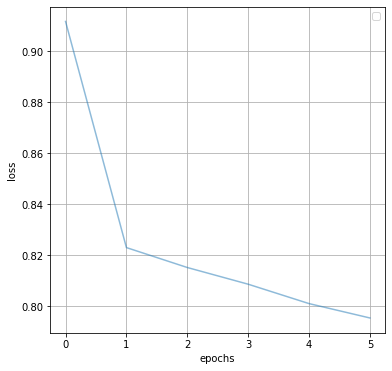

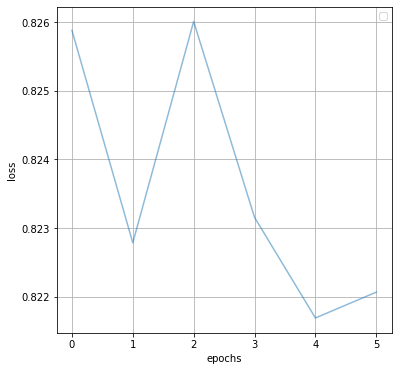

In [8]:
batch_size = 32
max_epoch = 6

# データをDataFrame型で読み込み
train_df = pd.read_csv('train.txt', sep='\t', names=['label', 'text'])
valid_df = pd.read_csv('valid.txt', sep='\t', names=['label', 'text'])
test_df = pd.read_csv('test.txt', sep='\t', names=['label', 'text'])

# DataLoaderへの読み込み
train_dataloader = torch.utils.data.DataLoader(
    TextDataset(train_df),
    shuffle=True,
    batch_size = batch_size
)

valid_dataloader = torch.utils.data.DataLoader(
    TextDataset(valid_df),
    shuffle=True,
    batch_size = batch_size
)

test_dataloader= torch.utils.data.DataLoader(TextDataset(test_df))

# モデルの定義
model = BERT()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# 最適化手法の設定
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

def train(model):
    model.train() # 訓練モードで実行
    train_loss = 0
    criterion = torch.nn.CrossEntropyLoss()
    for batch in train_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        optimizer.zero_grad()
        outputs = model(ids=b_input_ids, mask=b_input_mask)
        loss = criterion(outputs, b_labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    return train_loss

def validation(model):
    model.eval()# 訓練モードをオフ
    val_loss = 0
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad(): # 勾配を計算しない
        for batch in valid_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            outputs = model(ids=b_input_ids, mask=b_input_mask)
            loss = criterion(outputs, b_labels)
            val_loss += loss.item()
    return val_loss

train_loss_ = []
valid_loss_ = []

for epoch in range(max_epoch):
    train_ = train(model)
    valid_ = validation(model)
    train_loss = train_ / len(train_dataloader)
    valid_loss = valid_ / len(valid_dataloader)
    print('epoch:{0}\ttrain_loss:{1}'.format(epoch, train_loss))
    train_loss_.append(train_loss)
    valid_loss_.append(valid_loss)


model.eval()# 訓練モードをオフ
preds = []
for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    with torch.no_grad():     
        preds.append(model(ids=b_input_ids, mask=b_input_mask))

result =[]
for pred in preds:
    result.append(torch.argmax(pred).item())

count = 0
con = []
for x, y in zip(result, label_to_num(test_df['label'].values)):
    if x == y:
        count += 1
    con.append(f'pred:{x}\ttrue:{y}')
print(f'Accuracy:{float(count)/float(len(result))}')

# 損失をグラフにプロット
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.plot([i for i in range(len(train_loss_))], train_loss_, alpha=0.5)
plt.grid()
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig(f"train_loss.png")

plt.figure(figsize=(6,6))
plt.plot([i for i in range(len(valid_loss_))], valid_loss_, alpha=0.5)
plt.grid()
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig(f"valid_loss.png")